# Fixed Window Slicing for GAN Training Data

This notebook demonstrates how to use the new BurstFixedWindowSlicer for creating 4-minute windows with 50% overlap for GAN training.

## Key Features:
- Fixed 4-minute duration windows
- 50% overlap (2-minute step size)
- Burst-centered with 2-minute buffer zones
- Smart edge handling
- Direct scaling to 128×128 for GAN training


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

# Import our new slicing utilities
from slicing_utils_new import BurstFixedWindowSlicer, process_multiple_bursts

# Also import existing utilities for comparison
sys.path.append('../data_preprocessing')
from data_label import time_to_column_indices
from data_denoise import remove_horizontal_noise, remove_vertical_noise

print("✅ Imports successful!")

✅ Imports successful!


## 1. Setup and Configuration


In [3]:
# Configuration
CSV_FILE_PATH = '/Users/remiliascarlet/Desktop/MDP/transfer_learning/burst_data/csv/original/240728145301-Skyline High School.csv'
SAVE_DIR = '/Users/remiliascarlet/Desktop/MDP/transfer_learning/burst_data/csv/saved_window_128'

# Burst timing (replace with your actual burst times)
BURST_START_TIME = '18:12:36'  # Replace with actual onset time
BURST_END_TIME = '18:13:09'    # Replace with actual offset time

print(f"Source file: {os.path.basename(CSV_FILE_PATH)}")
print(f"Burst time: {BURST_START_TIME} to {BURST_END_TIME}")
print(f"Output directory: {SAVE_DIR}")


Source file: 240728145301-Skyline High School.csv
Burst time: 18:12:36 to 18:13:09
Output directory: /Users/remiliascarlet/Desktop/MDP/transfer_learning/burst_data/csv/saved_window_128


In [4]:
# Create the fixed window slicer
slicer = BurstFixedWindowSlicer(
    window_duration=4*60,    # 4 minutes
    overlap_ratio=0.5,       # 50% overlap
    target_size=(128, 128)   # 128×128 for GAN training
)


BurstFixedWindowSlicer initialized:
  Window duration: 240s (2400 samples)
  Overlap: 50.0% (step: 1200 samples)
  Buffer zone: 2min (1200 samples)
  Target size: (128, 128)


In [9]:
# Process the burst with fixed windows
result = slicer.slice_burst_with_fixed_windows(
    csv_file_path=CSV_FILE_PATH,
    burst_start_time=BURST_START_TIME,
    burst_end_time=BURST_END_TIME,
    save_dir=SAVE_DIR,
    apply_denoising=False,
    burst_type=3,
    cleaning_method="fast"
)

print(f"\n📊 Results Summary:")
print(f"   Windows generated: {len(result['windows'])}")
print(f"   Window positions: {result['positions']}")
print(f"   Files saved: {len(result['saved_files'])}")



Processing burst: 18:12:36 to 18:13:09
Source: 240728145301-Skyline High School.csv
Loading CSV file: 240728145301-Skyline High School.csv
  Data shape: (277016, 411)
  Time range: 14:53:01.050 to 22:37:57.172
  Frequency channels: 411
  Data transposed: (277016, 411) -> (411, 277016)
  Converting time strings to indices...
    Burst indices: [118915, 119242]
  Calculating slicing range...
    Burst: [118915, 119242] (duration: 327 samples)
    Total length: 277016 samples
    Ideal range: [117715, 120442]
    Final range: [117715, 120442]
    Coverage: 2727 samples (4.5 minutes)
  Extracting fixed windows...
    Window size: 2400 samples (240s)
    Step size: 1200 samples (120.0s)
    Extracted 3 windows
    Positions: [np.int64(117715), np.int64(118915), np.int64(120115)]
  Saving 3 windows to /Users/remiliascarlet/Desktop/MDP/transfer_learning/burst_data/csv/saved_window_128


Saving windows: 100%|██████████| 3/3 [00:00<00:00, 170.54it/s]

  Saved 3 files

✅ Processing completed!
   Generated 3 windows of size (128, 128)
   Saved to: /Users/remiliascarlet/Desktop/MDP/transfer_learning/burst_data/csv/saved_window_128

📊 Results Summary:
   Windows generated: 3
   Window positions: [np.int64(117715), np.int64(118915), np.int64(120115)]
   Files saved: 3


## 2. Visualize Original Data and Window Positions


Loading original data for window position visualization...
Loading CSV file: 240728145301-Skyline High School.csv
  Data shape: (277016, 411)
  Time range: 14:53:01.050 to 22:37:57.172
  Frequency channels: 411
  Data transposed: (277016, 411) -> (411, 277016)
Original data shape: (411, 277016)
Burst region: [118915, 119242] (duration: 32.7s)
Visualization region: [116915, 121242] (duration: 432.7s)


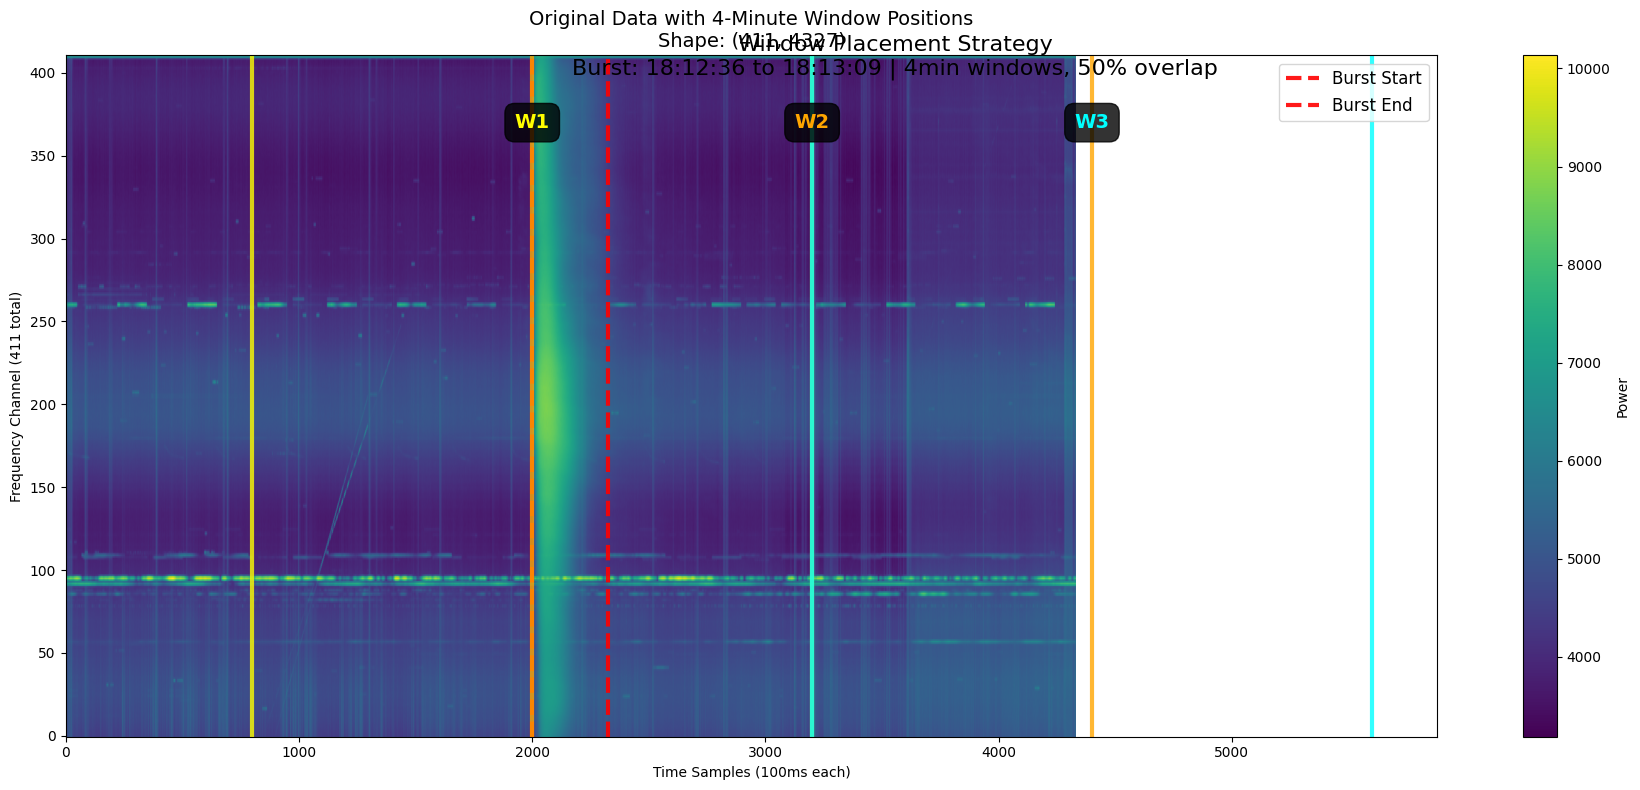


📊 Window Placement Analysis:
   Original data: (411, 277016) (freq×time)
   Burst duration: 32.7 seconds
   Window duration: 240 seconds
   Window overlap: 50.0%
   Step size: 1200 samples (120.0s)


In [7]:
# Load original data for window position visualization
print("Loading original data for window position visualization...")
original_data, times, raw_data = slicer.load_and_preprocess_csv(
    CSV_FILE_PATH, 
    apply_denoising=False  # Show original data to see window placement
)
transposed_original = slicer.transpose_data(original_data)

# Get burst indices
start_idx, end_idx = time_to_column_indices(times, BURST_START_TIME, BURST_END_TIME)

# Extract visualization region (larger area around burst)
vis_buffer = 2000  # Show 2000 samples (~3.3 minutes) before and after
vis_start = max(0, start_idx - vis_buffer)
vis_end = min(transposed_original.shape[1], end_idx + vis_buffer)
vis_data = transposed_original[:, vis_start:vis_end]

print(f"Original data shape: {transposed_original.shape}")
print(f"Burst region: [{start_idx}, {end_idx}] (duration: {(end_idx-start_idx)*0.1:.1f}s)")
print(f"Visualization region: [{vis_start}, {vis_end}] (duration: {(vis_end-vis_start)*0.1:.1f}s)")

# Create window position visualization
fig = plt.figure(figsize=(18, 8))

# Show original data with window positions
ax1 = plt.subplot(1, 1, 1)
im1 = ax1.imshow(vis_data, aspect='auto', origin='lower', cmap='viridis')
ax1.set_title(f'Original Data with 4-Minute Window Positions\nShape: {vis_data.shape}', fontsize=14)
ax1.set_ylabel('Frequency Channel (411 total)')
ax1.set_xlabel('Time Samples (100ms each)')

# Mark burst boundaries
burst_start_vis = start_idx - vis_start
burst_end_vis = end_idx - vis_start
ax1.axvline(burst_start_vis, color='red', linestyle='--', linewidth=3, alpha=0.9, label='Burst Start')
ax1.axvline(burst_end_vis, color='red', linestyle='--', linewidth=3, alpha=0.9, label='Burst End')

# Mark window positions
colors = ['yellow', 'orange', 'cyan', 'magenta', 'lime']
for i, pos in enumerate(result['positions']):
    if vis_start <= pos <= vis_end:
        window_start_vis = pos - vis_start
        window_end_vis = window_start_vis + slicer.window_samples
        
        # Window boundaries
        color = colors[i % len(colors)]
        ax1.axvline(window_start_vis, color=color, linestyle='-', linewidth=3, alpha=0.8)
        ax1.axvline(window_end_vis, color=color, linestyle='-', linewidth=3, alpha=0.8)
        
        # Window label
        ax1.text(window_start_vis + slicer.window_samples//2, vis_data.shape[0]*0.9, 
                f'W{i+1}', ha='center', va='center', 
                color=color, fontweight='bold', fontsize=14,
                bbox=dict(boxstyle='round,pad=0.5', facecolor='black', alpha=0.8))

ax1.legend(loc='upper right', fontsize=12)
plt.colorbar(im1, ax=ax1, label='Power')

plt.tight_layout()
plt.suptitle(f'Window Placement Strategy\nBurst: {BURST_START_TIME} to {BURST_END_TIME} | 4min windows, 50% overlap', 
             fontsize=16, y=0.95)
plt.show()

print(f"\n📊 Window Placement Analysis:")
print(f"   Original data: {transposed_original.shape} (freq×time)")
print(f"   Burst duration: {(end_idx-start_idx)*0.1:.1f} seconds")
print(f"   Window duration: {slicer.window_duration} seconds")
print(f"   Window overlap: {slicer.overlap_ratio*100}%")
print(f"   Step size: {slicer.step_samples} samples ({slicer.step_samples*0.1:.1f}s)")


## 3. RFI Cleaning Effect Comparison


In [ ]:
# # 🔍 Debug: RFI Detection Analysis
# print("🔍 Debugging RFI cleaning...")

# from denoise_new import AdvancedRFICleaner

# # Load original data
# raw_data = pd.read_csv(CSV_FILE_PATH, on_bad_lines='skip')
# spectral_data = raw_data.iloc[:, 2:]
# times = raw_data['Time']

# # Get burst indices  
# start_idx, end_idx = time_to_column_indices(times, BURST_START_TIME, BURST_END_TIME)

# # Test RFI cleaning with comprehensive mode
# cleaner = AdvancedRFICleaner(burst_type=3)
# cleaned_data, masks = cleaner.advanced_rfi_cleaning(
#     spectral_data,
#     burst_start_idx=start_idx,
#     burst_end_idx=end_idx,
#     apply_interpolation=True,
#     verbose=True,
#     fast_mode=True
# )

# # Analyze detection vs actual cleaning
# print(f"\n📊 Detection vs Cleaning Analysis:")
# print(f"   Vertical RFI detected: {np.sum(masks['vertical_rfi']):,} time columns")
# print(f"   Horizontal RFI detected: {np.sum(masks['horizontal_rfi']):,} frequency rows") 
# print(f"   Fine RFI detected: {np.sum(masks['fine_rfi']):,} pixels")
# print(f"   TOTAL pixels cleaned: {np.sum(masks['combined_rfi']):,}")

# # Calculate expected vs actual
# expected_vertical_pixels = np.sum(masks['vertical_rfi']) * spectral_data.shape[1]
# expected_horizontal_pixels = np.sum(masks['horizontal_rfi']) * spectral_data.shape[0]
# print(f"\n🔢 Expected vs Actual:")
# print(f"   Expected from vertical detections: {expected_vertical_pixels:,} pixels")
# print(f"   Expected from horizontal detections: {expected_horizontal_pixels:,} pixels")
# print(f"   Actually cleaned: {np.sum(masks['combined_rfi']):,} pixels")
# print(f"   Step 5 filtered out: {(expected_vertical_pixels + expected_horizontal_pixels - np.sum(masks['combined_rfi'])):,} pixels")

# # Check protection coverage
# if masks['protection_mask'] is not None:
#     protection_ratio = np.sum(masks['protection_mask']) / masks['protection_mask'].size
#     print(f"\n🛡️  Protection Analysis:")
#     print(f"   Protection coverage: {protection_ratio*100:.1f}% of total data")
#     print(f"   Protection margin: 200 samples (20 seconds)")

# # Data change analysis
# data_diff = np.abs(spectral_data.values - cleaned_data)
# significant_changes = np.sum(data_diff > 0.1)  # Changes > 0.1
# print(f"\n📈 Actual Data Changes:")
# print(f"   Pixels with changes > 0.1: {significant_changes:,}")
# print(f"   Change percentage: {significant_changes/spectral_data.size*100:.3f}%")
# print(f"   Max change: {np.max(data_diff):.1f}")
# print(f"   Mean change: {np.mean(data_diff):.4f}")

# if significant_changes < 1000:
#     print(f"\n⚠️  Very few actual changes detected!")
#     print(f"   Possible issues:")
#     print(f"   1. Protection mask too large (covering vis region)")
#     print(f"   2. Step 5 filtering too aggressive") 
#     print(f"   3. Parameters too conservative")


In [ ]:
# ## 4. Final Generated Windows (128×128 for GAN Training)

# # 📊 Visualize Denoise Before vs After
# print("📊 Creating denoise comparison visualization...")

# # Use the data from debug cell above (spectral_data = original, cleaned_data = after cleaning)

# # Transpose both for visualization
# raw_transposed = spectral_data.values.T[::-1]
# cleaned_transposed = cleaned_data.T[::-1]

# # Extract burst region for comparison
# vis_buffer = 1500  # Show area around burst
# vis_start = max(0, start_idx - vis_buffer)
# vis_end = min(raw_transposed.shape[1], end_idx + vis_buffer)

# raw_vis = raw_transposed[:, vis_start:vis_end]
# cleaned_vis = cleaned_transposed[:, vis_start:vis_end]

# # Create simple before/after comparison
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))

# # 1. Original data
# im1 = ax1.imshow(raw_vis, aspect='auto', origin='lower', cmap='viridis')
# ax1.set_title('BEFORE: Original Data with RFI', fontsize=14)
# ax1.set_ylabel('Frequency Channel')

# # Mark burst
# burst_start_vis = start_idx - vis_start
# burst_end_vis = end_idx - vis_start
# ax1.axvline(burst_start_vis, color='red', linestyle='--', linewidth=2, label='Burst')
# ax1.axvline(burst_end_vis, color='red', linestyle='--', linewidth=2)
# ax1.legend()
# plt.colorbar(im1, ax=ax1)

# # 2. Cleaned data
# im2 = ax2.imshow(cleaned_vis, aspect='auto', origin='lower', cmap='viridis')
# ax2.set_title('AFTER: RFI Cleaned Data', fontsize=14)
# ax2.set_ylabel('Frequency Channel')
# ax2.axvline(burst_start_vis, color='red', linestyle='--', linewidth=2, label='Burst')
# ax2.axvline(burst_end_vis, color='red', linestyle='--', linewidth=2)
# ax2.legend()
# plt.colorbar(im2, ax=ax2)

# # 3. Difference (what was removed)
# diff_vis = raw_vis - cleaned_vis
# im3 = ax3.imshow(diff_vis, aspect='auto', origin='lower', cmap='RdBu_r', vmin=-500, vmax=500)
# ax3.set_title('DIFFERENCE: What was removed (Red=RFI removed, Blue=Data reduced)', fontsize=14)
# ax3.set_xlabel('Time Samples')
# ax3.set_ylabel('Frequency Channel')
# ax3.axvline(burst_start_vis, color='black', linestyle='--', linewidth=2, label='Burst')
# ax3.axvline(burst_end_vis, color='black', linestyle='--', linewidth=2)
# ax3.legend()
# plt.colorbar(im3, ax=ax3)

# plt.tight_layout()
# plt.suptitle(f'RFI Cleaning Comparison\nBurst: {BURST_START_TIME} to {BURST_END_TIME}', fontsize=16, y=0.98)
# plt.show()

# # Simple statistics
# print(f"\n📊 Simple Comparison Statistics:")
# print(f"   Original max: {raw_vis.max():.0f}, Cleaned max: {cleaned_vis.max():.0f}")
# print(f"   Original mean: {raw_vis.mean():.1f}, Cleaned mean: {cleaned_vis.mean():.1f}")
# print(f"   Difference max: {np.abs(diff_vis).max():.1f}")
# print(f"   Pixels with difference > 10: {np.sum(np.abs(diff_vis) > 10):,}")

# if np.sum(np.abs(diff_vis) > 10) > 1000:
#     print("   ✅ RFI cleaning is having visible effect")
# else:
#     print("   ⚠️  RFI cleaning effect is minimal - check debug output above")

📊 Displaying final 128×128 windows for GAN training...


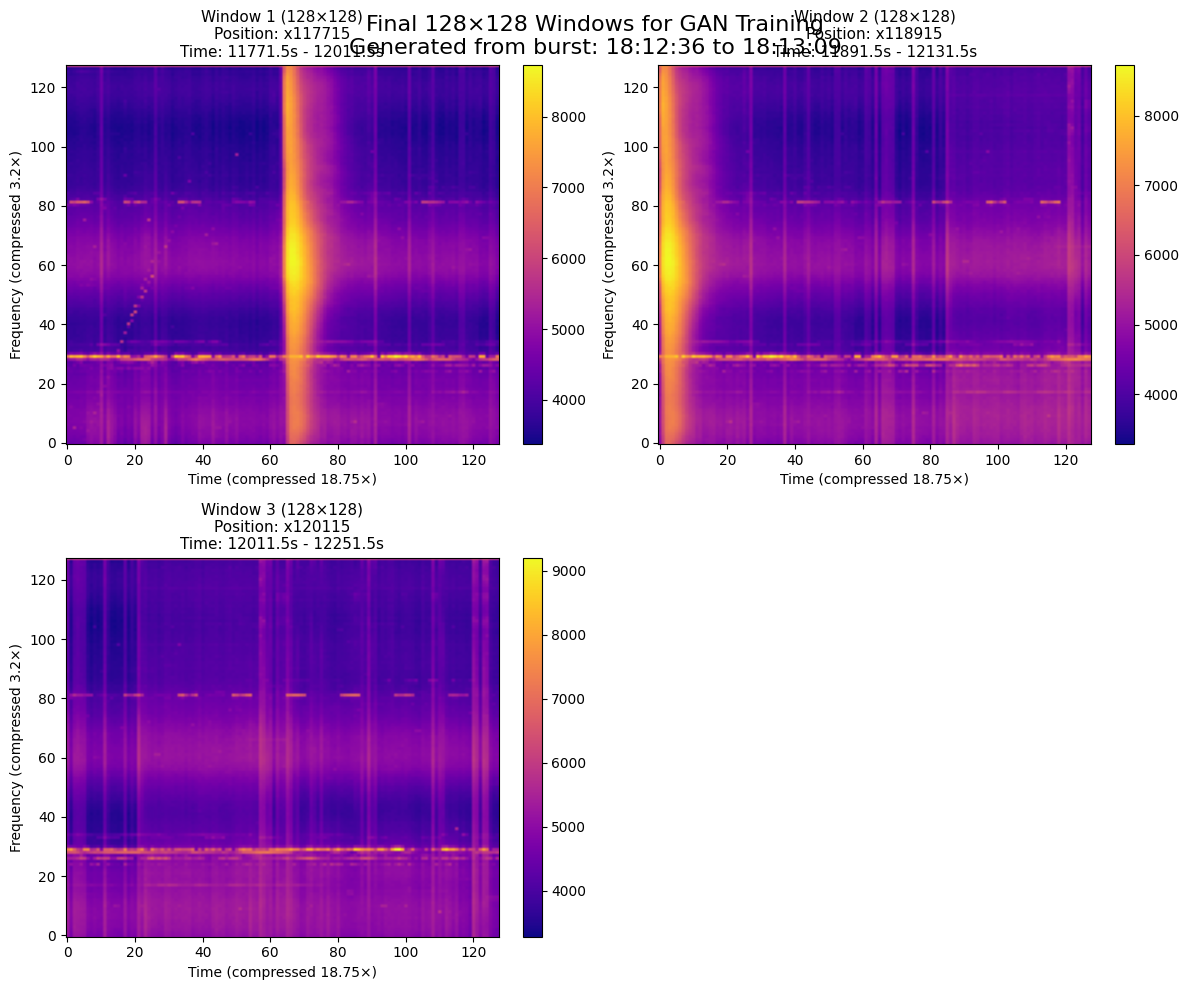


📈 Final Data Statistics:
   Generated windows: 3
   Window size: (128, 128)
   Compression ratios:
     Time: 2400→128 (18.8×)
     Frequency: 411→128 (3.2×)
     Total: 60.2× data reduction

📋 Window Details for GAN Training:
   Window 1: x117715 (11771.5s-12011.5s)
     Shape: (128, 128) | Range: [3373.716, 8726.379] | Mean: 4577.840
   Window 2: x118915 (11891.5s-12131.5s)
     Shape: (128, 128) | Range: [3280.053, 8726.379] | Mean: 4714.479
   Window 3: x120115 (12011.5s-12251.5s)
     Shape: (128, 128) | Range: [3280.053, 9207.338] | Mean: 4561.967

🎯 GAN Training Ready:
   All 3 windows are 128×128 and ready for DCGAN training
   Data format: Float arrays normalized for neural network input
   File location: Not saved


In [10]:
# Display final generated 128×128 windows
print("📊 Displaying final 128×128 windows for GAN training...")

windows = result['windows']
positions = result['positions']
num_windows = len(windows)

# Create window display
fig, axes = plt.subplots(2, max(2, (num_windows+1)//2), figsize=(6*max(2, (num_windows+1)//2), 10))
if num_windows == 1:
    axes = [axes]
elif len(axes.shape) == 1:
    axes = axes.reshape(1, -1)

# Display each generated window
for i in range(num_windows):
    row = i // ((num_windows + 1) // 2)
    col = i % ((num_windows + 1) // 2)
    
    if row < axes.shape[0] and col < axes.shape[1]:
        ax = axes[row, col]
        im = ax.imshow(windows[i], aspect='auto', origin='lower', cmap='plasma')
        
        # Calculate time info
        start_time_s = positions[i] * 0.1  # Convert to seconds
        end_time_s = (positions[i] + slicer.window_samples) * 0.1
        
        ax.set_title(f'Window {i+1} (128×128)\nPosition: x{positions[i]}\nTime: {start_time_s:.1f}s - {end_time_s:.1f}s', 
                    fontsize=11)
        ax.set_xlabel('Time (compressed 18.75×)')
        ax.set_ylabel('Frequency (compressed 3.2×)')
        plt.colorbar(im, ax=ax, fraction=0.046)

# Hide unused subplots
for i in range(num_windows, axes.size):
    row = i // axes.shape[1]
    col = i % axes.shape[1]
    if row < axes.shape[0] and col < axes.shape[1]:
        axes[row, col].set_visible(False)

plt.tight_layout()
plt.suptitle(f'Final 128×128 Windows for GAN Training\nGenerated from burst: {BURST_START_TIME} to {BURST_END_TIME}', 
             fontsize=16, y=0.98)
plt.show()

# Detailed statistics
print(f"\n📈 Final Data Statistics:")
print(f"   Generated windows: {num_windows}")
print(f"   Window size: {slicer.target_size}")
print(f"   Compression ratios:")
print(f"     Time: {slicer.window_samples}→128 ({slicer.window_samples/128:.1f}×)")
print(f"     Frequency: 411→128 ({411/128:.1f}×)")
print(f"     Total: {slicer.window_samples*411/(128*128):.1f}× data reduction")

print(f"\n📋 Window Details for GAN Training:")
for i, (window, pos) in enumerate(zip(windows, positions)):
    start_time = pos * 0.1
    end_time = (pos + slicer.window_samples) * 0.1
    print(f"   Window {i+1}: x{pos} ({start_time:.1f}s-{end_time:.1f}s)")
    print(f"     Shape: {window.shape} | Range: [{window.min():.3f}, {window.max():.3f}] | Mean: {window.mean():.3f}")

print(f"\n🎯 GAN Training Ready:")
print(f"   All {num_windows} windows are 128×128 and ready for DCGAN training")
print(f"   Data format: Float arrays normalized for neural network input")
print(f"   File location: {result['metadata'].get('save_dir', 'Not saved')}")
